In [1]:
#Installing the user-defined package
pip install -i https://test.pypi.org/simple/ my-krml-24587139

Looking in indexes: https://test.pypi.org/simple/
Note: you may need to restart the kernel to use updated packages.


## Importing Libraries and Datasets

In [2]:
import numpy as np
import pandas as pd

In [3]:
items_weekly_sell_prices = pd.read_csv('../data/raw/items_weekly_sell_prices.csv')

In [4]:
calendar_events = pd.read_csv('../data/raw/calendar_events.csv')
calendar = pd.read_csv('../data/raw/calendar.csv')
sales_test = pd.read_csv('../data/raw/sales_test.csv')
sales_train = pd.read_csv('../data/raw/sales_train.csv')

### Merging Tables

In [5]:
from my_krml_24587139.data.sets import combine_tables

sales_calendar_prices = combine_tables(sales_train=sales_train, calendar = calendar, 
                                       calendar_events = calendar_events, items_weekly_sell_prices = items_weekly_sell_prices)

## Obtaining the total sales revenue for Time Series

In [6]:
sales_calendar_prices['sales_total_earning'] = sales_calendar_prices['items_sold'] * sales_calendar_prices['sell_price']

In [7]:
df = pd.DataFrame(sales_calendar_prices.groupby('date')['sales_total_earning'].sum())

In [8]:
from my_krml_24587139.data.sets import fixing_features_prophet

df = fixing_features_prophet(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1541 entries, 0 to 1540
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1541 non-null   datetime64[ns]
 1   y       1541 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 24.2 KB
None
          ds         y
0 2011-01-29  81650.61
1 2011-01-30  78970.57
2 2011-01-31  57706.91
3 2011-02-01  60761.20
4 2011-02-02  46959.95


In [9]:
df.head()

,ds,y
0,2011-01-29,81650.61
1,2011-01-30,78970.57
2,2011-01-31,57706.91
3,2011-02-01,60761.20
4,2011-02-02,46959.95


In [10]:
from my_krml_24587139.data.sets import split_sets_times_series

X_train,  X_val,  X_test,  = split_sets_times_series(df)

In [11]:
df

,ds,y
0,2011-01-29,81650.61
1,2011-01-30,78970.57
2,2011-01-31,57706.91
3,2011-02-01,60761.20
4,2011-02-02,46959.95
...,...,...
1536,2015-04-14,102896.92
1537,2015-04-15,106913.88
1538,2015-04-16,98373.49
1539,2015-04-17,103030.58


In [12]:
X_train

,ds,y
1534,2015-04-12,150877.68
894,2013-07-11,97425.26
1375,2014-11-04,97257.73
459,2012-05-02,77669.74
810,2013-04-18,77967.42
...,...,...
26,2011-02-24,53986.34
927,2013-08-13,93482.77
397,2012-03-01,81947.28
358,2012-01-22,89315.46


## Model Training

In [13]:
!pip install prophet

In [14]:
from my_krml_24587139.models.modelling import training_prophet

C:\Users\ASUS\AppData\Local\pypoetry\Cache\virtualenvs\at2-ttFDl4Zd-py3.9\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [15]:
prophet = training_prophet(X_train)

02:46:48 - cmdstanpy - INFO - Chain [1] start processing
02:46:49 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
from joblib import dump
dump(prophet,  '../models/forecasting/prophet.joblib')

['../models/forecasting/prophet.joblib']

## Prediction

In [17]:
train_preds = prophet.predict(X_train)
val_preds = prophet.predict(X_val)
test_preds = prophet.predict(X_test)

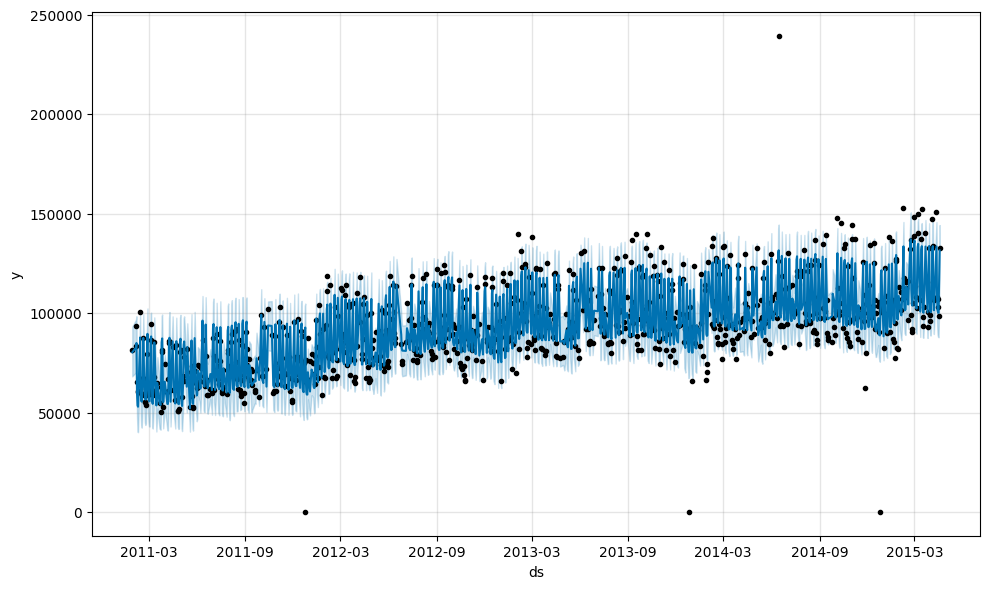

In [18]:
plot1 = prophet.plot(train_preds)

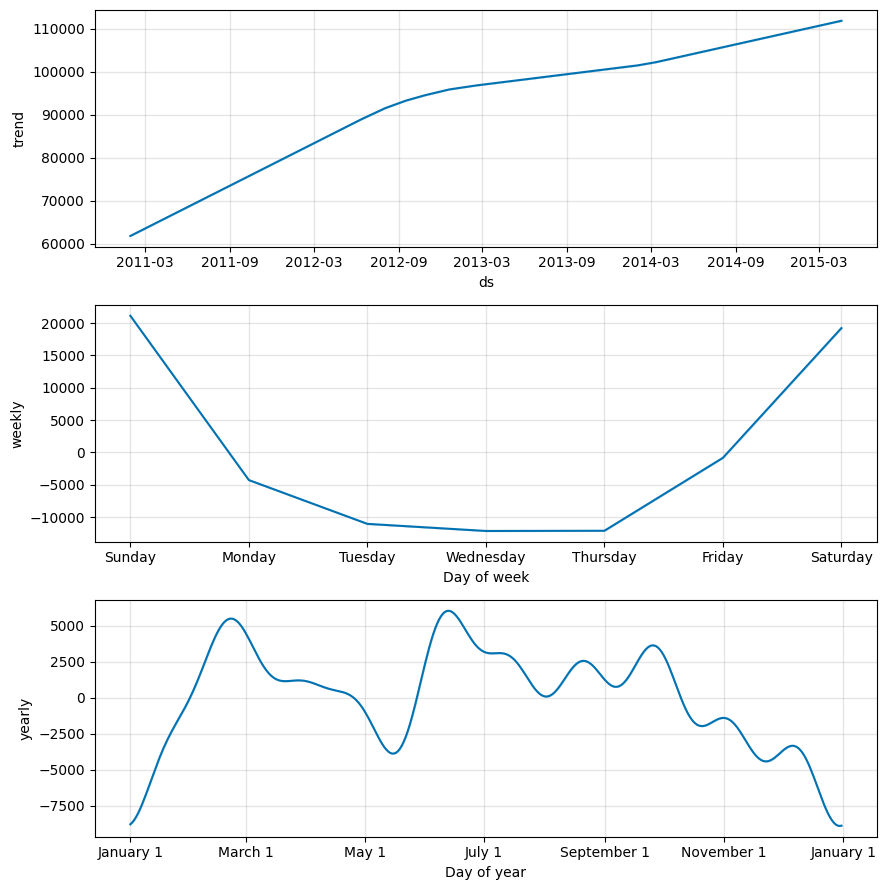

In [19]:
plt2 = prophet.plot_components(train_preds)

In [20]:
from my_krml_24587139.models.performance import print_rmse_scores

print_rmse_scores(y_train=X_train['y'],
                  train_pred=train_preds['yhat'], 
                  y_val=X_val['y'], 
                  val_pred=val_preds['yhat'], 
                  y_test=X_test['y'], 
                  test_pred=test_preds['yhat'])

Training RMSE: 27381.2396262266
Validation RMSE: 28335.361299585715
Test RMSE: 28691.139070005804


In [21]:
# Reset index
X_test.reset_index(inplace=True)
results = pd.DataFrame({
    'Date': X_test['ds'],
    'Actual': X_test['y'],
    'Predicted': test_preds['yhat']
})

In [26]:
!pip install seaborn

  Using cached seaborn-0.13.0-py3-none-any.whl (294 kB)


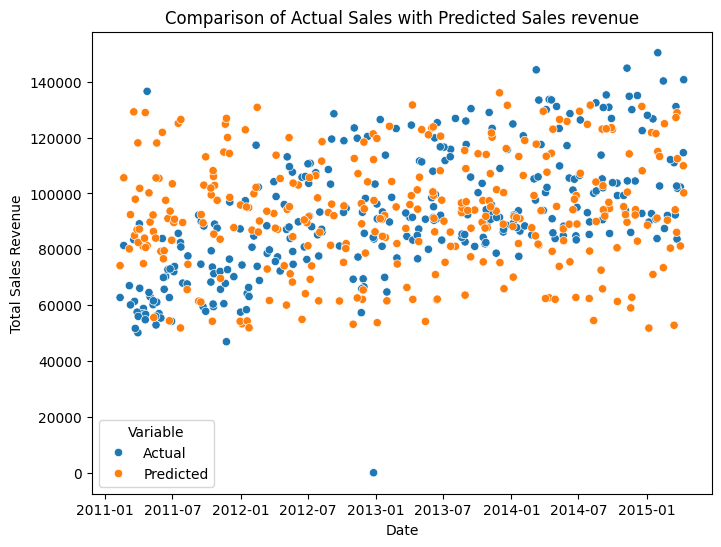

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns


results_long = results.melt(id_vars='Date', var_name='Variable', value_name='Val')

# Plot using Seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Date', y='Val', hue='Variable', data=results_long)
plt.xlabel('Date')
plt.ylabel('Total Sales Revenue')
plt.title('Comparison of Actual Sales with Predicted Sales revenue')
plt.show()

## References

1. Duca, Angelica Lo. ‘Understanding the Prophet Plot’. Syntax-Error, 3 July 2022, https://medium.com/syntaxerrorpub/understanding-the-prophet-plot-b5b6856371f4.

2. An Introduction to Seaborn — Seaborn 0.13.0 Documentation. https://seaborn.pydata.org/tutorial/introduction.html. Accessed 15 Oct. 2023.